In [2]:
import numpy as np, matplotlib.pyplot as plt, glob, os, regex as re, matplotlib as mpl, \
    scipy.stats as stats, seaborn as sns, scipy as sp, matplotlib.gridspec as gridspec, \
    matplotlib.colors as mplcol, json

In [3]:
MODE = 'rawmvmt' # 'wavelet'

### Specify data files to display

In [4]:
if MODE == 'wavelet':
    fnameBases = ['\\\\?\\Z:\\behavior\\*\\wavelet\\wavelet_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_1_20_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy',
                  '\\\\?\\Z:\\behavior\\*\\wavelet\\wavelet_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_1_20_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy'
    ]
else:
    fnameBases = ['\\\\?\\Z:\\behavior\\*\\wavelet\\rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy',
                  '\\\\?\\Z:\\behavior\\*\\wavelet\\rawmvmt_dlc_euclidean_no-abspos_no-vel_00000010001000000010001000_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy'
    ]

In [5]:
fnames = [[(x if i == 0 else None) for x in glob.glob(fnameBase) if 'RIG' not in x] \
          for i, fnameBase in enumerate(fnameBases)]

fnames[1] = [x.replace(os.path.basename(fnameBases[0]), os.path.basename(fnameBases[1])) for x in fnames[0]]

len(fnames[0]), fnames[0][0:2]

(21,
 ['\\\\?\\Z:\\behavior\\4-10-19-b\\wavelet\\rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy',
  '\\\\?\\Z:\\behavior\\4-11-19-a\\wavelet\\rawmvmt_dlc_euclidean-midline_no-abspos_no-vel_00000000010001000000010001_60_16_meansub_scalestd_hipow_tsne_no-pca_perplexity_100_200000_2000_euclidean.npy'])

In [6]:
# Load data
Hs = [[], []]
for k in range(2):
    arrs = []
    for fname in fnames[k]:
        arr = np.load(fname)
        arr = arr[~np.any(np.isnan(arr), axis=1)]
        arrs.append(arr)

    # Determine data range
    _max, _min = np.max(np.vstack(arrs), axis=0), np.min(np.vstack(arrs), axis=0)

    # Compute histograms
    for arr in arrs:
        H, _, _ = np.histogram2d(
            arr[:,0], arr[:,1],
            bins=(200, 200), 
            range=((_min[0], _max[0]), (_min[1], _max[1])))

        # Clip
        H = np.clip(H, 0, np.percentile(H, 99))
        H = H / np.sum(H)

        Hs[k].append(H)

In [7]:
fnamesJSON = [os.path.abspath(os.path.join(os.path.dirname(x), '../recording.json')) for x in fnames[0]]
recordingInfo = []
for fnJSON in fnamesJSON:
    with open(fnJSON, 'r') as f:
        recordingInfo.append(json.load(f))

In [8]:
hasStabilimentum = [(len(x['stages']['stabilimentum']) > 0) for x in recordingInfo]

In [9]:
isCanonical = [np.all([len(ri['stages'][st]) <= 1 for st in ri['stages'] if len(ri['stages'][st]) > 0 \
    and isinstance(ri['stages'][st][0], (list, tuple))]) for ri in recordingInfo]

In [10]:
def jsd(p, q, base=np.e):
    """Implementation of pairwise `jsd` based on: 
       https://en.wikipedia.org/wiki/Jensen%E2%80%93Shannon_divergence
    """
    # convert to np.array
    p, q = np.asarray(p), np.asarray(q)
    # normalize p, q to probabilities
    p, q = p/p.sum(), q/q.sum()
    m = 0.5 * (p + q)
    return stats.entropy(p.flatten(), m.flatten(), base=base)/2. + \
        sp.stats.entropy(q.flatten(), m.flatten(), base=base)/2.

In [11]:
# Determine spider ID labels
def getSpiderID(x):
    k = ['a', 'b', 'd', 'e', 'mvs~'].index(re.search('[0-9]+-[0-9]+-[0-9]+-([a-z~]*)', x).group(1))
    return ['A', 'B', 'C', 'D', 'E'][k]

In [12]:
# Wong colorblind-safe palette
# Source: https://www.nature.com/articles/nmeth.1618
# Source: https://davidmathlogic.com/colorblind/#%23648FFF-%23785EF0-%23DC267F-%23FE6100-%23FFB000
COLORS = [
    (0, 0, 0),
    (230, 159, 0),
    (0, 158, 115),
    (204, 121, 167),
    (86, 180, 233)
]
COLORS = [mplcol.rgb2hex(np.array(x) / 255.0) for x in COLORS]

### Plot dendrogram

In [13]:
from shapely.geometry import Point, LineString
from matplotlib.path import Path
import shapely.affinity

In [14]:
xy = np.zeros((6, 2))
xy[:,0] = np.linspace(0, 1, xy.shape[0])
xy[:,1] = ((np.arange(0, xy.shape[0])%2)-0.5) * 0.3
shape = shapely.affinity.rotate(LineString(xy).buffer(0.02), 45)
path = np.array(shape.exterior.xy).T - np.array(shape.centroid.xy).T
stabilimentumMarker = Path(path)

In [15]:
# Get other recordings by this individual
def getRecordingOrder(fn):
    datesSameSpider = [(a, '{:02}-{:02}-{:02}'.format(int(z), int(x), int(y))) for a, (x, y, z) in [
        (x==fn, re.search('([0-9]{1,2})-([0-9]{1,2})-([0-9]{2})', x).groups()) for x \
        in fnames[0] if getSpiderID(fn)==getSpiderID(x)]]
    if len(datesSameSpider) == 1:
        return -1
    else:
        return [i for i, x in enumerate(sorted(datesSameSpider, key=lambda x: x[1])) if x[0]][0]

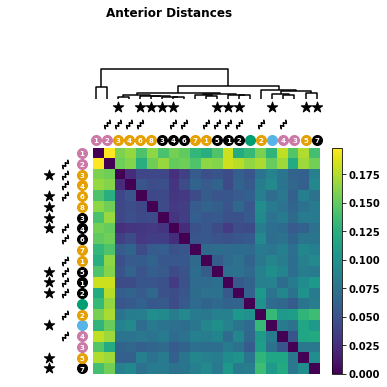

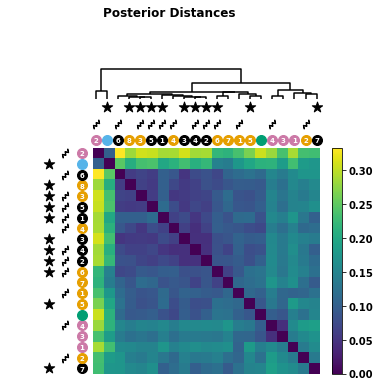

In [16]:
for k in range(2):
    # Compute pairwise distances
    distMtx = np.zeros((len(Hs[0]), len(Hs[0])), dtype=np.float64)
    for i1 in range(distMtx.shape[0]):
        for i2 in range(distMtx.shape[1]):
            distMtx[i1, i2]  = jsd(Hs[0][i1], Hs[0][i2]) * k
            distMtx[i1, i2] += jsd(Hs[1][i1], Hs[1][i2]) * (1-k)
    
    fig = plt.figure(figsize=(6, 6))
    spec = gridspec.GridSpec(ncols=7, nrows=7, 
        width_ratios =[1, 0.5, 0.5, 0.5, 7, 0.3, 0.3], 
        height_ratios=[1, 0.5, 0.5, 0.5, 7, 0.3, 0.3], wspace=0, hspace=0)

    # Plot dendrogram (left, empty)
    ax = fig.add_subplot(spec[4, 0])
    ax.set_axis_off()

    # Plot dendrogram
    ax = fig.add_subplot(spec[0, 4])
    link = sp.cluster.hierarchy.linkage(np.hstack((distMtx, distMtx.T)), 
        method='ward', metric='euclidean')
    dendr = sp.cluster.hierarchy.dendrogram(link, 
        ax=ax, link_color_func=lambda x:'black')
    ax.set_axis_off()

    # Plot heatmap
    order = sp.cluster.hierarchy.leaves_list(link)
    ax = fig.add_subplot(spec[4, 4], clip_on=False)
    img = ax.imshow(distMtx[:,order][order,:], cmap='viridis')
    ax.set_axis_off()
    
    # Get IDs
    spiderIDs = np.vectorize(getSpiderID)(np.array(fnames[0])[order])
    recordingOrders = np.vectorize(getRecordingOrder)(np.array(fnames[0])[order])
    
    # Plot spider labels (top)
    ax = fig.add_subplot(spec[3, 4], clip_on=False)
    
    for i, (spiderID, recordingOrder) in enumerate(zip(spiderIDs, recordingOrders)):
        ax.scatter(i + 0.5, 0, s=100, 
                   color=COLORS[np.unique(spiderIDs).tolist().index(spiderID) + 0])
        if recordingOrder >= 0:
            ax.text(i + 0.5, -0.05, '{}'.format(recordingOrder + 1), 
                    fontsize=7, color='white', ha='center', va='center')
    ax.set_xlim(0, 21)
    ax.set_ylim(-0.5, 0.5)
    ax.set_axis_off()

    # Plot spider stabilimentum (top)
    ax = fig.add_subplot(spec[2, 4])
    for i, spiderID in enumerate(spiderIDs):    
        # Draw spider identity
        if hasStabilimentum[order[i]]:
            ax.scatter((i + 0.5), 0, s=80, color='black', marker=stabilimentumMarker)
    ax.set_xlim(0, 21)
    ax.set_ylim(-0.5, 0.5)
    ax.set_axis_off()
    
    # Plot spider canonical/noncanonical (top)
    ax = fig.add_subplot(spec[1, 4])
    for i, spiderID in enumerate(spiderIDs):    
        # Draw spider identity
        if not isCanonical[order[i]]:
            ax.scatter((i + 0.5), 0, s=120, marker='*', color='black')
    ax.set_xlim(0, 21)
    ax.set_ylim(-0.5, 0.5)
    ax.set_axis_off()
    
    # Plot spider labels (left)
    ax = fig.add_subplot(spec[4, 3])
    for i, (spiderID, recordingOrder) in enumerate(zip(spiderIDs[::-1], recordingOrders[::-1])):    
        # Draw spider identity
        ax.scatter(0, i + 0.5, s=100, color=COLORS[np.unique(spiderIDs).tolist().index(spiderID) + 0])
        if recordingOrder >= 0:
            ax.text(0, i + 0.5 - 0.05, '{}'.format(recordingOrder + 1), 
                    fontsize=7, color='white', ha='center', va='center')
    ax.set_ylim(0, 21)
    ax.set_xlim(-0.5, 0.5)
    ax.set_axis_off()
    
    # Plot spider stabilimentum (left)
    ax = fig.add_subplot(spec[4, 2])
    for i, spiderID in enumerate(spiderIDs[::-1]):    
        # Draw spider identity
        if hasStabilimentum[order[i]]:
            ax.scatter(0, 21 - (i + 0.5), s=80, color='black', marker=stabilimentumMarker)
    ax.set_ylim(0, 21)
    ax.set_xlim(-0.5, 0.5)
    ax.set_axis_off()
    
    # Plot spider canonical/noncanonical (left)
    ax = fig.add_subplot(spec[4, 1])
    for i, spiderID in enumerate(spiderIDs[::-1]):    
        # Draw spider identity
        if not isCanonical[order[i]]:
            ax.scatter(0, 21 - (i + 0.5), s=120, marker='*', color='black')
    ax.set_ylim(0, 21)
    ax.set_xlim(-0.5, 0.5)
    ax.set_axis_off()

    # Plot color scale
    ax = fig.add_subplot(spec[4, 6])
    plt.colorbar(img, cax=ax)
    
    # ...
    fig.suptitle(['Anterior Distances', 'Posterior Distances'][k], y=1.02)

    # Save
    #fig.show()
    fig.savefig('C:/Users/acorver/Desktop/paper-figures/Fig{}_2c_{}.pdf'.format(
        '_suppl' if MODE=='wavelet' else '', k), bbox_inches='tight')